In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

# Forward

A parameteric neural network (PNN) can be help a NN learn to interpolate between important phase space quantities. 
However, a downwise to these networks is that each phase space point that is underconsideration must be evaluated on both signal and background

Instead of training the PNN on all available phase space points, we can imagine sectioning of the phase space in some way that in each section of phase space the network is as optimal as it can be for that section.
Since the relationship between the phase space and target is not known, it may be possible to train a second NN to section the phase space in a way that is optimal for the PNN.

## First concept
The first concept that seemed to work well is using an AutoEncoder to compress that parameteric features down to a 1D latent space.
Where each feature in the latent space corresponds to a section of the phase space.
This latent space embedding can then be used to train the PNN.

To evaluate the network, we can specify which of the sections of the latent space we want to evaluate on. 

In [2]:
import torch
import pickle

class Dataset(torch.utils.data.Dataset):
    def __init__(self, path):

        ttree = []
        for f in os.listdir(path):
            with open(f'{path}/{f}', 'rb') as f:
                ttree.append(pickle.load(f))

        self.ttree = ak.concatenate(ttree, axis=0)

    def __len__(self): return len(self.ttree)

    def __getitem__(self, idx):
        return self.inputs[idx], self.parameters[idx], self.targets[idx]

    def expr(self, expr):
        import ast
        scope = dict(ak=ak, np=np, len=len)

        # get fields referenced in expression
        fields = set()
        for node in ast.walk(ast.parse(expr)):
            if isinstance(node, ast.Name):
                fields.add(node.id)
        fields = fields - set(scope.keys())

        # get fields from tree
        fields = { field: self.ttree[field] for field in fields }

        # evaluate expression
        return eval(expr, scope, fields)

    @property
    def input_dims(self):
        return self.inputs.shape[1]

    @property
    def inputs(self):
        if hasattr(self, '_inputs'): return self._inputs

        variables = [ f'{p}.{f}' for p in ('y1', 'y2') for f in ('pt','m','eta','phi') ]
        arrays = []
        for variable in variables:
            array = self.expr(variable)
            if array.ndim == 1: array = array[:,None]
            arrays.append(array)
        
        self._inputs = ak.to_numpy(ak.concatenate(arrays, axis=1)).astype(np.float32)
        return self._inputs
                
    @property
    def parameter_dims(self):
        return self.parameters.shape[1]

    @property
    def parameters(self):
        if hasattr(self, '_parameters'): return self._parameters

        parameters = ['mx', 'my']
        arrays = []
        for parameter in parameters:
            array = self.expr(parameter)
            if array.ndim == 1: array = array[:,None]
            arrays.append(array)

        self._parameters = ak.to_numpy(ak.concatenate(arrays, axis=1)).astype(np.float32)

        bkg_mask = np.all(self._parameters == -1, axis=1)
        sig_mask = ~bkg_mask

        sampled_index = np.random.choice(np.where(sig_mask)[0], size=np.sum(bkg_mask), replace=True)
        self._parameters[bkg_mask] = self._parameters[sampled_index]

        return self._parameters

    @property
    def targets(self):
        if hasattr(self, '_targets'): return self._targets

        self._targets = ak.to_numpy(self.ttree.class_label).astype(np.int64)
        return self._targets


In [3]:
training_dataset = Dataset('data/training')
testing_dataset = Dataset('data/testing')

In [4]:
trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader( testing_dataset, batch_size=128, shuffle=False)

In [5]:
for batch in trainloader:
    break

In [6]:
import pytorch_lightning as pl
import torchmetrics

In [7]:
def draw_phase_partition(model, dataset):
    min_mx, min_my = dataset.parameters.min(axis=0)
    max_mx, max_my = dataset.parameters.max(axis=0)

    mx = np.linspace(0.5*min_mx, 1.5*max_mx, 100)
    my = np.linspace(0.5*min_my, 1.5*max_my, 100)

    xlim = mx[[0,-1]]
    ylim = my[[0,-1]]

    mx, my = np.meshgrid(mx, my)
    mx, my = mx.flatten(), my.flatten()

    mask = (mx > 2 * my)
    mx, my = mx[mask], my[mask]
    model.eval()

    with torch.no_grad():
        _, latent = model.parameter_encoder.encode(torch.tensor([mx, my]).T.float())

    scores, partition = latent.max(dim=1)
    fig, axs = study.get_figax(nvar=1)

    graph2d_array(
        mx, my, partition,
        interp=dict(kind='linear'),
        colorbar=True,
        g_cmap='tab10',
        zlim=np.arange(model.parameter_encoding+1), figax=(fig, axs),
        
    )

    format_axes(axs, xlim=xlim, ylim=ylim, xlabel='mx', ylabel='my')

In [8]:
class ParameterAutoEncoder(pl.LightningModule):
    def __init__(self, n_fts, embedding=[16, 32], n_emb=2):
        super().__init__()

        self.n_fts = n_fts
        self.embedding = embedding
        self.n_emb = n_emb
        self.act = torch.nn.LeakyReLU()

        embedding = [n_fts] + embedding + [n_emb]

        self.feature_norm = torch.nn.BatchNorm1d(n_fts, affine=False)
        layers = [
                    layer
                    for n_in, n_out in zip(embedding[:-1], embedding[1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1] + [ torch.nn.Softmax(dim=1) ]
        self.encoder = torch.nn.Sequential(*layers)

        layers = [
                    layer
                    for n_in, n_out in zip(embedding[::-1][:-1], embedding[::-1][1:])
                    for layer in [ torch.nn.Linear(n_in, n_out), self.act ]
                ][:-1]
        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        x, embed = self.encode(x)
        xhat = self.decoder(embed)
        return x, embed, xhat

    def encode(self, x):
        x = self.feature_norm(x)
        embed = self.encoder(x)
        return x, embed

    def one_hot_encode(self, parameters):
        _, embed = self.encode(parameters)
        return self.one_hot(embed.argmax(dim=1))

    def one_hot(self, idx):
        idx = idx[:,None]
        one_hot = torch.zeros(len(idx), self.n_emb, device=self.device)
        one_hot.scatter_(1, idx, 1)
        return one_hot

    def step(self, parameters):
        x = parameters
        x, embed, xhat = self(x)

        mse_loss = torch.nn.functional.mse_loss(xhat, x)
        loss = mse_loss

        # max_loss = torch.nn.functional.mse_loss(embed, self.one_hot(torch.argmax(embed, axis=1)))
        # loss = loss + 0 * max_loss

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch['parameters'])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [9]:
from typing import Any

class AutoPPN(pl.LightningModule):
    def __init__(self, 
                 input_dims,
                 parameter_dims,

                 input_embedding=[16, 32],
                 parameter_embedding=[16, 32],
                 parameter_encoding=3,

                 classifier_embedding=[32, 16],
                 classes=2,
                 ):
        super().__init__()

        self.input_dims = input_dims
        self.parameter_dims = parameter_dims
        self.parameter_encoding = parameter_encoding

        self.act = torch.nn.LeakyReLU()

        self.parameter_encoder = ParameterAutoEncoder(parameter_dims, parameter_embedding, parameter_encoding)

        input_embedding = [input_dims] + input_embedding
        layers = [
            layer
            for n_in, n_out in zip(input_embedding[:-1], input_embedding[1:])
            for layer in (torch.nn.Linear(n_in, n_out), self.act)
        ]
        self.input_embedding = torch.nn.Sequential(*layers[:-1])

        parameter_embedding = [parameter_encoding] + input_embedding
        layers = [
            layer
            for n_in, n_out in zip(parameter_embedding[:-1], parameter_embedding[1:])
            for layer in (torch.nn.Linear(n_in, n_out), self.act)
        ]
        self.parameter_embedding = torch.nn.Sequential(*layers[:-1])

        input_classifier = [input_embedding[-1]] + classifier_embedding + [classes]
        layers = [
            torch.nn.Linear(n_in, n_out)
            for n_in, n_out in zip(input_classifier[:-1], input_classifier[1:])
        ]
        self.input_classifier = torch.nn.ModuleList(layers)

        parameter_classifier = [parameter_embedding[-1]] + classifier_embedding + [classes]
        layers = [
            torch.nn.Linear(n_in, n_out)
            for n_in, n_out in zip(parameter_classifier[:-1], parameter_classifier[1:])
        ]
        self.parameter_classifier = torch.nn.ModuleList(layers)

        self.auroc = torchmetrics.AUROC('multiclass', num_classes=classes)

    def forward(self, x, parameters):
        x = self.input_embedding(x)

        _, parameters = self.parameter_encoder.encode(parameters)
        parameters = self.parameter_embedding(parameters)
        x = x + parameters

        for input_layer, parameter_layer in zip(self.input_classifier[:-1], self.parameter_classifier[:-1]):
            parameters = parameter_layer(parameters)
            x = self.act(input_layer(x) + parameters)

        parameters = self.parameter_classifier[-1](parameters)
        x = self.input_classifier[-1](x) + parameters

        return torch.nn.functional.softmax(x, dim=1)

    def training_step(self, batch, batch_idx=None):
        inputs, parameters, targets = batch

        probs = self(inputs, parameters)

        auroc = self.auroc(probs, targets)
        self.log('auroc', auroc, on_epoch=True, on_step=False, prog_bar=True)

        loss = torch.nn.functional.cross_entropy(probs, targets)
        loss = loss + self.parameter_encoder.step(parameters)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [10]:
def train_model():
    model = AutoPPN(
        training_dataset.input_dims,
        training_dataset.parameter_dims,
        
        input_embedding = [16, 32],
        parameter_embedding = [16, 32],
        parameter_encoding = 4,

        classifier_embedding = [32, 16],
        classes = 2,
    )

    trainer = pl.Trainer(max_epochs=10, accelerator='cpu')
    trainer.fit(model, trainloader)

    draw_phase_partition(model, testing_dataset)

    return model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | act                  | LeakyReLU            | 0     
1 | parameter_encoder    | ParameterAutoEncoder | 1.4 K 
2 | input_embedding      | Sequential           | 688   
3 | parameter_embedding  | Sequential           | 728   
4 | input_classifier     | ModuleList           | 1.6 K 
5 | parameter_classifier | ModuleList           | 1.6 K 
6 | auroc                | MulticlassAUROC      | 0     
--------------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


AutoPPN(
  (act): LeakyReLU(negative_slope=0.01)
  (parameter_encoder): ParameterAutoEncoder(
    (act): LeakyReLU(negative_slope=0.01)
    (feature_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=4, bias=True)
      (5): Softmax(dim=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (input_embedding): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)


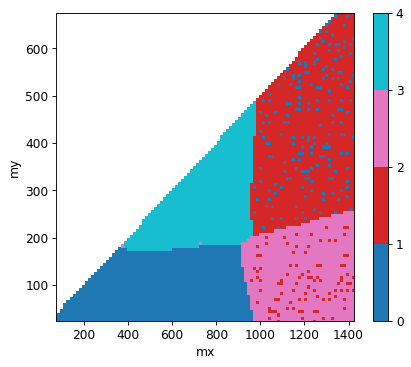

In [11]:
train_model()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | act                  | LeakyReLU            | 0     
1 | parameter_encoder    | ParameterAutoEncoder | 1.4 K 
2 | input_embedding      | Sequential           | 688   
3 | parameter_embedding  | Sequential           | 728   
4 | input_classifier     | ModuleList           | 1.6 K 
5 | parameter_classifier | ModuleList           | 1.6 K 
6 | auroc                | MulticlassAUROC      | 0     
--------------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


AutoPPN(
  (act): LeakyReLU(negative_slope=0.01)
  (parameter_encoder): ParameterAutoEncoder(
    (act): LeakyReLU(negative_slope=0.01)
    (feature_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=4, bias=True)
      (5): Softmax(dim=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (input_embedding): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)


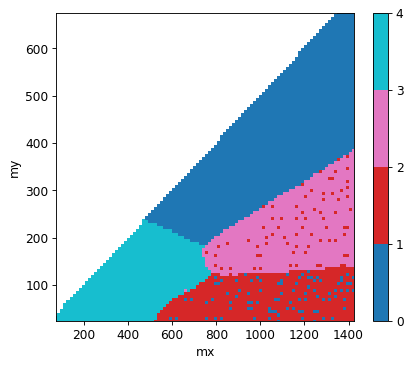

In [12]:
train_model()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | act                  | LeakyReLU            | 0     
1 | parameter_encoder    | ParameterAutoEncoder | 1.4 K 
2 | input_embedding      | Sequential           | 688   
3 | parameter_embedding  | Sequential           | 728   
4 | input_classifier     | ModuleList           | 1.6 K 
5 | parameter_classifier | ModuleList           | 1.6 K 
6 | auroc                | MulticlassAUROC      | 0     
--------------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


AutoPPN(
  (act): LeakyReLU(negative_slope=0.01)
  (parameter_encoder): ParameterAutoEncoder(
    (act): LeakyReLU(negative_slope=0.01)
    (feature_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=4, bias=True)
      (5): Softmax(dim=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (input_embedding): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)


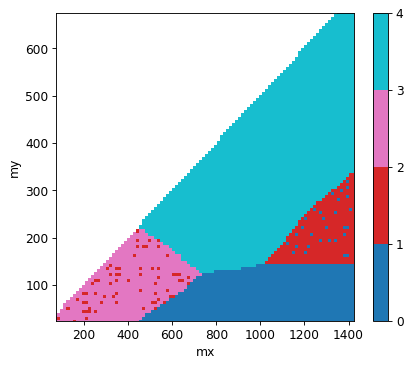

In [13]:
train_model()

In [33]:
with torch.no_grad():
    (signal+bkg).apply(
        lambda t : t.extend(
            nominal_score=nominal_model.eval().predict( torch.from_numpy(dataset.get_inputs(t)).float() )[:,1].numpy()
        )
    )

In [34]:
predict_section = lambda t, s : model.eval().predict(
            torch.from_numpy(dataset.get_inputs(t)).float(),
            torch.ones(len(t), dtype=torch.int64) * s,
        )[:,1].numpy()

with torch.no_grad():
    (signal+bkg).apply(
        lambda t : t.extend(
        **{
                f'section_{s}_score':predict_section(t, s)
                for s in range(model.autoencoder.n_emb)
            }
        )
    )

100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


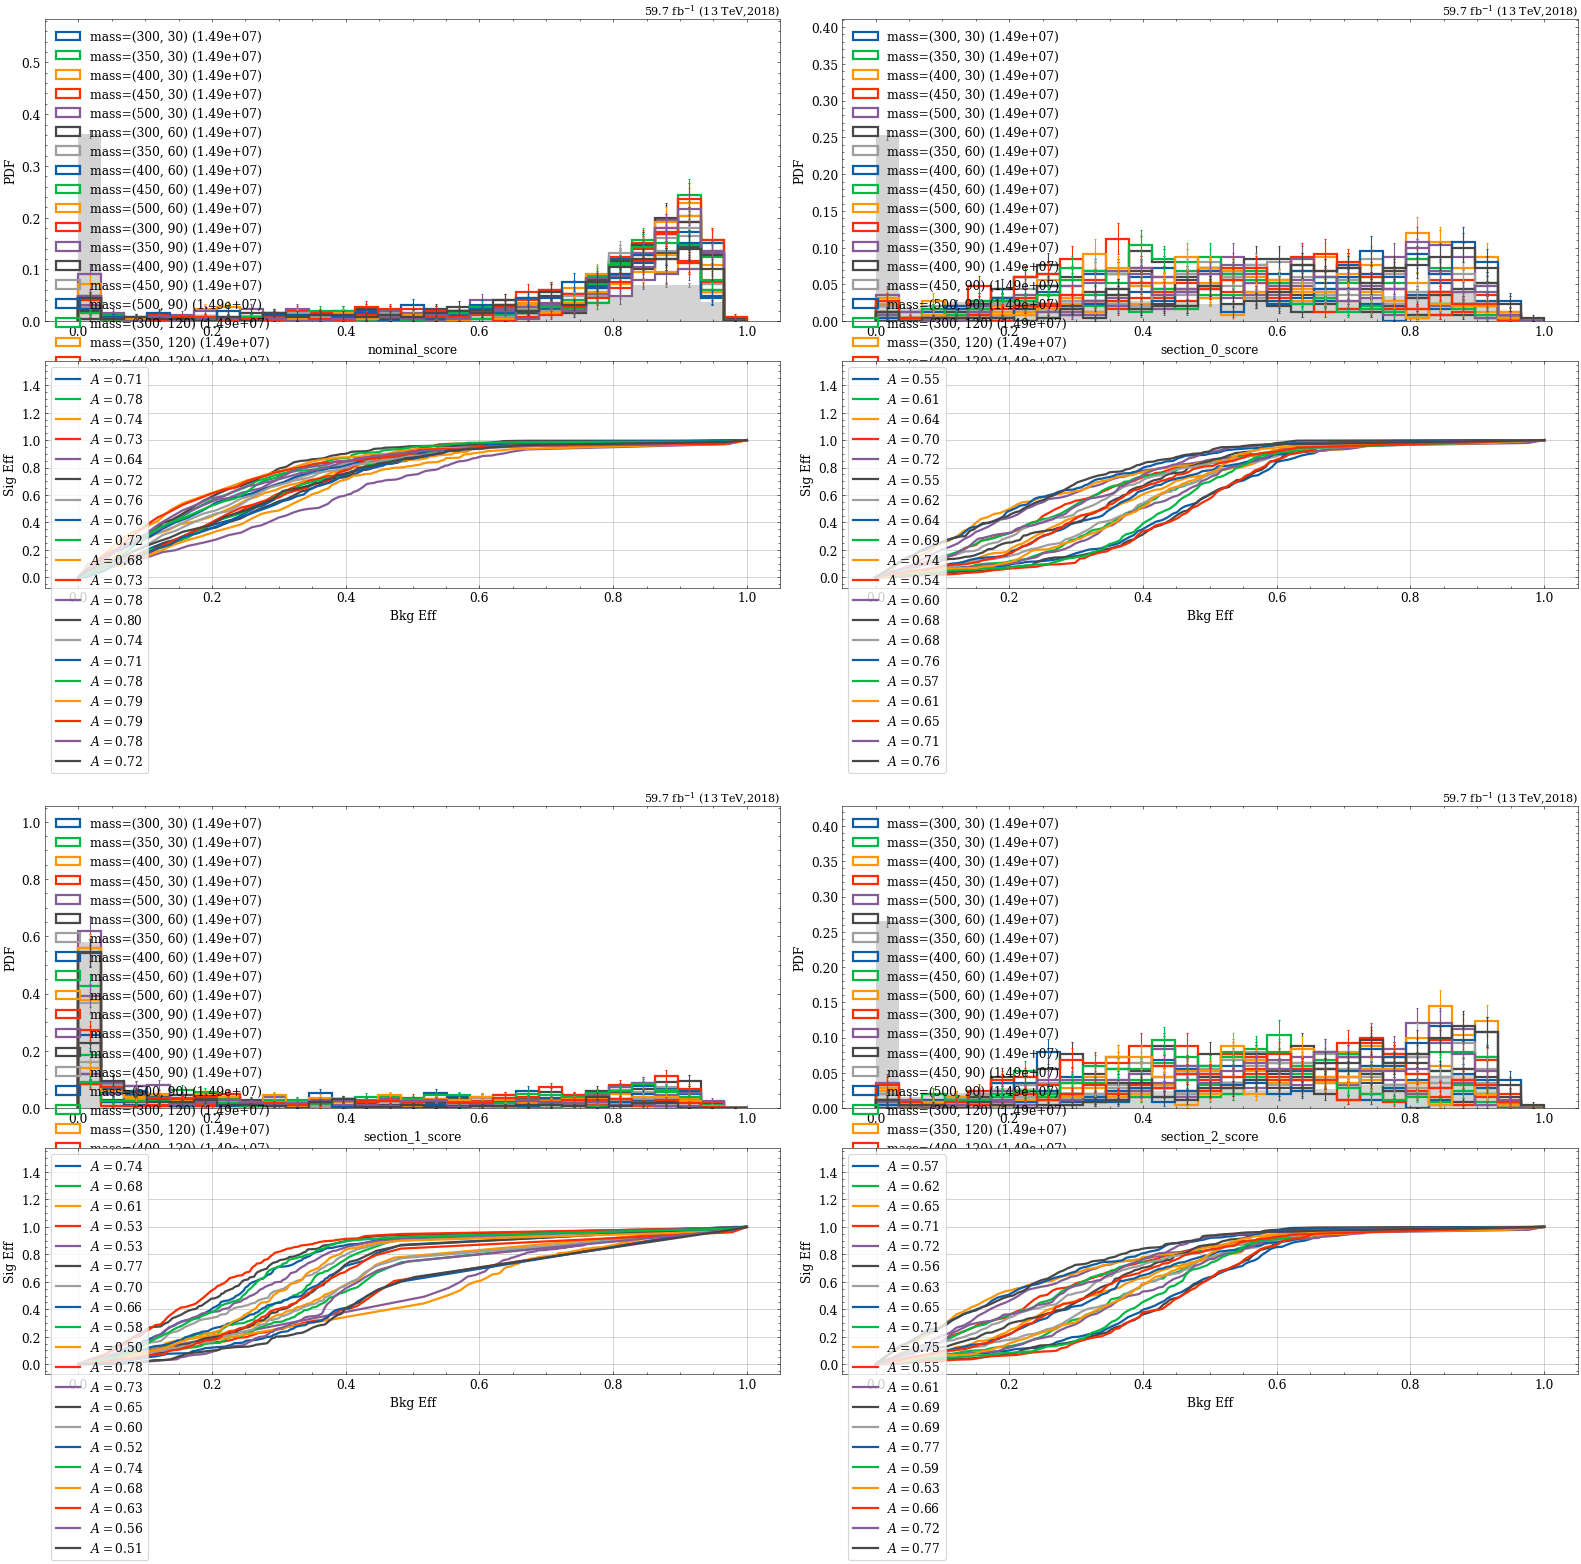

In [35]:
store = obj_store()
study.quick(
    signal + bkg,
    varlist=['nominal_score'] + [f'section_{s}_score' for s in range(model.autoencoder.n_emb)],
    binlist=[(0, 1, 30)] * 100,
    efficiency=True, legend=True,
    **study.auroc,

    e_c_store=store,

    size=(10, 10)
)

In [36]:
def get_info(correlation):
    auroc = correlation.stats.area

    sig = correlation._y_
    label = sig.kwargs['label']

    match = re.match(r'mass=\((\d+), (\d+)\)', label)

    mx = int(match.group(1))
    my = int(match.group(2))

    parameter = torch.tensor([[mx, my]], dtype=torch.float32)
    with torch.no_grad():
        latent = model.eval().autoencoder.encoder(parameter).numpy()

    score = ak.max(latent, axis=1)
    section = ak.where( score > 0.8, ak.argmax(latent, axis=1), 0)

    return dict(
        mx = mx,
        my = my,
        auroc = auroc,
        section = section[0],
        section_score=score[0],
    )

In [37]:
model_auroc = store[0]
section_auroc = store[1:]

nominal = ObjIter(model_auroc).apply(get_info).awk
sections = [ ObjIter(section).apply(get_info).awk for section in section_auroc ]
section_auroc = ak.concatenate([ section.auroc[:,None] for section in sections ], axis=1)
section_index = ak.local_index(section_auroc)

nominal['section_auroc'] = section_auroc[section_index == nominal.section][:,0]
nominal['optimal_section'] = ak.fill_none(ak.argmax(section_auroc, axis=1), np.nan)
nominal['optimal_section_auroc'] = ak.fill_none(ak.max(section_auroc, axis=1), np.nan)

In [38]:
ak.mean(nominal.optimal_section_auroc/nominal.auroc)

0.9680631570284849

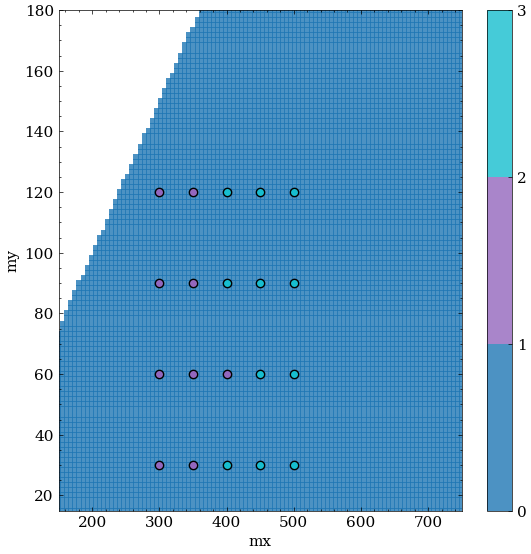

In [39]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots()

graph2d_array(
    mx, my, c,
    interp=dict(kind='linear'),
    colorbar=True,
    g_cmap='tab10',
    g_alpha=0.8,
    zlim=np.arange(model.autoencoder.n_emb+1), figax=(fig, ax),
)

cmap = plt.cm.get_cmap('tab10')
norm = mpl.colors.BoundaryNorm(boundaries=np.arange(model.autoencoder.n_emb+1), ncolors=cmap.N)

for i in range(model.autoencoder.n_emb):
    graph_array(nominal.mx[nominal.optimal_section == i], nominal.my[nominal.optimal_section == i], g_linestyle='none', g_markeredgecolor='black', figax=(fig, ax), g_color=cmap(norm(i)))
format_axes(ax, xlim=mx[[0,-1]], ylim=my[[0,-1]], xlabel='mx', ylabel='my')